# Строчка 1

Описательный анализ данных в `train` и `validation`

In [1]:
import pandas as pd
import numpy as np

In [2]:
datka_train = pd.read_csv('data/jigsaw-toxic-comment-train.csv')
datka_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
datka_test = pd.read_csv('data/test.csv')
datka_test.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [4]:
datka_val = pd.read_csv('data/validation.csv')
datka_val.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


Уникальные языки в тестовой выборке:

In [5]:
datka_val.lang.unique()

array(['es', 'it', 'tr'], dtype=object)

В поезде только один язык: английский. Попробуем прикинуть, как выглядит распределение

Сколько всего примеров

In [6]:
grouped_val = datka_val[['lang', 'toxic']].groupby('lang')
grouped_val.count()

,toxic
lang,
es,2500
it,2500
tr,3000


In [7]:
pd.DataFrame({'lang': ['en'], 'toxic': datka_val.toxic.count()})

,lang,toxic
0,en,8000


Сколько из них токсичных

In [8]:
grouped_val.sum()

,toxic
lang,
es,422
it,488
tr,320


In [9]:
pd.DataFrame({'lang': ['en'], 'toxic': datka_val.toxic.sum()})

,lang,toxic
0,en,1230


Средняя токчичность

In [10]:
grouped_val.mean()

,toxic
lang,
es,0.168800
it,0.195200
tr,0.106667


In [11]:
pd.DataFrame({'lang': ['en'], 'toxic': datka_val.toxic.mean()})

,lang,toxic
0,en,0.15375


Посмотрим на среднюю длину

In [16]:
datka_train[['comment_text', 'toxic']].groupby('toxic').comment_text.apply(lambda x: np.mean(x.str.len()))

toxic
0    402.691178
1    280.604097
Name: comment_text, dtype: float64

In [17]:
datka_val[['comment_text', 'toxic']].groupby('toxic').comment_text.apply(lambda x: np.mean(x.str.len()))

toxic
0    378.600148
1    316.082114
Name: comment_text, dtype: float64

Итак, токсичные комментарии в обоих выборках короче

# Строчка 2

Бейзлайн модель из sklearn (векторайзер + модель) с отбором признаков (через l1 регуляризацию, на глаз через анализ важных параметров или через permutation importance) - 2 балл

In [5]:
import eli5
from eli5.sklearn import PermutationImportance
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [6]:
X_train, X_test, y_train, y_test = \
    train_test_split(
        datka_train.comment_text,
        datka_train.toxic, test_size=0.1, random_state=42
    )

In [26]:
cv = CountVectorizer(50)
cv_train = cv.fit_transform(X_train)
cv_test = cv.transform(X_test)

In [31]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [121]:
## Так оно слишком долго считает
# params = {
#     'C': [x / 10 for x in range(1, 11)],
#     'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
# }

# model = GridSearchCV(LogisticRegression(), params, cv=folds, n_jobs=-1, verbose=True)
model = LogisticRegression()

In [122]:
model.fit(cv_train, y_train)

/home/misha/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/misha/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [123]:
train_preds = model.predict_proba(cv_train)[:, 1]
test_preds = model.predict_proba(cv_test)[:, 1]
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test, test_preds)))

result on train: 0.9533359910656112
result on test: 0.9444930727272449


Вообще, здесь очень хорошие результаты даёт мультиноминальный наивный байес с гридсёрчем. Но его не поддерживает эли, поэтому придётся довольствоваться логистической регрессией

In [124]:
top_features = eli5.formatters.as_dataframe.explain_weights_df(model)
top_features.head()

,target,feature,weight
0,1,x84758,3.083016
1,1,x84806,2.544450
2,1,x102720,2.285985
3,1,x197892,2.285411
4,1,x187561,2.194650


In [125]:
top_features = [int(i[1:]) for i in top_features.feature if 'BIAS' not in i]

In [126]:
cv_train_eli5 = cv_train[:,top_features]
cv_test_eli5 = cv_test[:,top_features]

In [127]:
new_model = LogisticRegression()

In [128]:
new_model = model.fit(cv_train_eli5, y_train)
train_preds = new_model.predict_proba(cv_train_eli5)[:, 1]
test_preds = new_model.predict_proba(cv_test_eli5)[:, 1]
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))

/home/misha/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


result on train: 0.9520942734770398
result on test: 0.9437854746290602


/home/misha/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Строчка 3

Ансамбль из моделей в sklearn (ансамблевые модели типа randomforest не считаются). Нужно минимум 5 разных моделей - 2 балла

Сделаем `voting` с подбором весов

In [145]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from mlxtend.classifier import StackingClassifier

In [131]:
def print_metrics(predictions):
    print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))

In [132]:
def get_predictions(weights):
    clf1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1)
    clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
    clf3 = GaussianNB()
    clf4 = MultinomialNB(alpha=0.1, fit_prior=True)
    clf5 = KNeighborsClassifier(n_neighbors=2) 

    eclf = VotingClassifier(
        estimators=[
            ('lr', clf1), ('rf', clf2), ('gnb', clf3),
            ('mnb', clf4), ('knc', clf5),
        ],
        voting='hard',
        weights=weights,
    )

    voting = Pipeline([
        ('vect', CountVectorizer(analyzer='word', max_features=500)),
        ('tfidf', TfidfTransformer(sublinear_tf=True)),
        ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
        ('clf', eclf),
    ])
    voting = voting.fit(X_train, y_train)
    predictions = voting.predict(X_test)
    return predictions

In [133]:
def get_f1(weights, f=get_predictions):
    return m.f1_score(y_test, f(weights), average='macro')

In [ ]:
# Веса я подбирал в домашке и для других данных
# На наших данных это занимает слишком много времени, поэтому
# Будет считать, что веса взяты от балды
# Но в целом алгоритм подбора такой:
# 
# import warnings
# warnings.filterwarnings("ignore")

# best_score = 0
# best_weights = None
# for weights in product(*[[1, 2]] * 5):
#     f1 = get_f1(weights)
#     if f1 > best_score:
#         best_score = f1
#         best_weights = weights
# best_weights

In [ ]:
predictions = get_predictions((2, 2, 1, 1, 2))

In [141]:
# В ячейке выше ошибка была в `print_metrics`,
# Поэтому я очистил вывод
print_metrics(predictions)

Precision:   0.90
Recall:   0.71
F1-measure:   0.77
Accuracy:   0.94


# Строчка 4


Любая нейронная модель (минимум 5 слоев) с Dropout, Pooling и колбеками - 2 балла

In [184]:
del predictions
del model
del new_model
del top_features
del train_preds
del test_preds
del grouped_val
del cv
del cv_train
del cv_test

In [6]:
import tensorflow as tf
from collections import Counter
from nltk import word_tokenize

In [7]:
vocab = Counter()

for text in datka_train.comment_text:
    vocab.update(word_tokenize(text))

len(vocab)

432613

In [8]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

len(filtered_vocab)

13218

In [9]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [11]:
X = []

for text in datka_train.comment_text:
    tokens = word_tokenize(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [12]:
MAX_LEN = max(len(x) for x in X)
MAX_LEN

4948

In [13]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(223549, 4948)

In [14]:
y = datka_train.toxic

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [16]:
del X

In [17]:
weights = np.zeros((len(word2id), 100))
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(
    input_dim=len(word2id), output_dim=100,
    trainable=False, weights=[weights]
)(inputs)
sum_ = tf.keras.layers.Lambda(
    lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(sum_)
dense = tf.keras.layers.Dense(64, activation='relu')(sum_)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [18]:
model1.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=10,
)

W0625 01:51:00.482849 140645751338816 network.py:957] Model was constructed with shape (None, 100) for input Tensor("input_1:0", shape=(None, 100), dtype=float32), but it was called on an input with incompatible shape (None, 4948).


Epoch 1/10


W0625 01:51:00.719475 140645751338816 network.py:957] Model was constructed with shape (None, 100) for input Tensor("input_1:0", shape=(None, 100), dtype=float32), but it was called on an input with incompatible shape (None, 4948).


415/415 [==============================] - ETA: 0s - loss: 0.2459 - root_mean_squared_error: 0.4958

W0625 01:53:09.593125 140645751338816 network.py:957] Model was constructed with shape (None, 100) for input Tensor("input_1:0", shape=(None, 100), dtype=float32), but it was called on an input with incompatible shape (None, 4948).


415/415 [==============================] - 128s 308ms/step - loss: 0.2459 - root_mean_squared_error: 0.4958 - val_loss: 0.2419 - val_root_mean_squared_error: 0.4918
Epoch 2/10
415/415 [==============================] - 124s 299ms/step - loss: 0.2378 - root_mean_squared_error: 0.4876 - val_loss: 0.2340 - val_root_mean_squared_error: 0.4838
Epoch 3/10
415/415 [==============================] - 127s 306ms/step - loss: 0.2300 - root_mean_squared_error: 0.4796 - val_loss: 0.2265 - val_root_mean_squared_error: 0.4759
Epoch 4/10
415/415 [==============================] - 126s 305ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717 - val_loss: 0.2193 - val_root_mean_squared_error: 0.4683
Epoch 5/10
415/415 [==============================] - 127s 307ms/step - loss: 0.2153 - root_mean_squared_error: 0.4641 - val_loss: 0.2123 - val_root_mean_squared_error: 0.4608
Epoch 6/10
415/415 [==============================] - 130s 314ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565 - val_loss: 

In [18]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(word2id),
    output_dim=100,
)(inputs)

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(drop1)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
pool = tf.keras.layers.AveragePooling1D()(conv2)

concat = tf.keras.layers.Flatten()(pool)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model.weights', monitor='val_f1', verbose=1,
    save_weights_only=True, save_best_only=True,
    mode='max', save_freq='epoch'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1', min_delta=0.01, patience=3,
    verbose=1, mode='max',
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[f1],
)

In [20]:
h = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=10,
    callbacks=[checkpoint, early_stop],
)

Epoch 1/10
830/830 [==============================] - ETA: 0s - loss: 0.1616 - f1: 0.5745
Epoch 00001: val_f1 improved from -inf to 0.71699, saving model to model.weights
830/830 [==============================] - 546s 658ms/step - loss: 0.1616 - f1: 0.5745 - val_loss: 0.1198 - val_f1: 0.7170
Epoch 2/10
830/830 [==============================] - ETA: 0s - loss: 0.1045 - f1: 0.7649
Epoch 00002: val_f1 improved from 0.71699 to 0.74263, saving model to model.weights
830/830 [==============================] - 516s 622ms/step - loss: 0.1045 - f1: 0.7649 - val_loss: 0.1227 - val_f1: 0.7426
Epoch 3/10
830/830 [==============================] - ETA: 0s - loss: 0.0864 - f1: 0.8076
Epoch 00003: val_f1 did not improve from 0.74263
830/830 [==============================] - 514s 619ms/step - loss: 0.0864 - f1: 0.8076 - val_loss: 0.1338 - val_f1: 0.7388
Epoch 4/10
830/830 [==============================] - ETA: 0s - loss: 0.0741 - f1: 0.8422
Epoch 00004: val_f1 did not improve from 0.74263
830/830 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


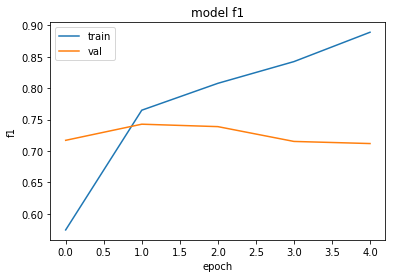

In [24]:
import matplotlib.pyplot as plt
print(h.history.keys())
# summarize history for accuracy
plt.plot(h.history['f1'])
plt.plot(h.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Ну, что-то получилось!

# Строчка 5

Использование нескольких видов эмбедингов в одной модели - 1.75 балла

Здесь возьмём не самую большу можель, а поменьше

In [17]:
corpus = datka_train.comment_text.apply(word_tokenize).tolist()

In [18]:
import gensim
import matplotlib.pyplot as plt

In [19]:
w2v = gensim.models.Word2Vec(corpus)
ft = gensim.models.FastText(corpus)

In [20]:
del corpus

In [21]:
def get_weights(model):
    weights = np.zeros((len(word2id), model.vector_size))
    for word, i in word2id.items():
        if word == 'PAD':
            continue
        if word == 'UNK':
            weights[i] = model.wv.get_vector("adopted") 
        try:
            weights[i] = model.wv.get_vector(word)
        except KeyError:
            weights[i] = model.wv.get_vector("adopted") 
    return weights

In [22]:
ft_weights = get_weights(ft)
w2v_weights = get_weights(w2v)

In [23]:
del w2v
del ft

In [24]:
embed = \
    lambda w: tf.keras.layers.Embedding(
        input_dim=len(word2id), output_dim=100,
        trainable=False, weights=[w],
    )(inputs)

In [25]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Concatenate()([
    embed(ft_weights),
    embed(w2v_weights),
])
transformed = tf.keras.layers.Flatten()(embeddings)

dense = tf.keras.layers.Dense(64, activation="relu")(transformed)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(dense)
model4 = tf.keras.Model(inputs=inputs, outputs=outputs)
model4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model.weights', monitor='val_accuracy', verbose=1,
    save_weights_only=True, save_best_only=True,
    mode='max', save_freq='epoch'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.01, patience=3,
    verbose=1, mode='max',
)

In [27]:
h = model4.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=128,
    epochs=15,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/15
1660/1660 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9234
Epoch 00001: val_accuracy improved from -inf to 0.93425, saving model to model.weights
1660/1660 [==============================] - 392s 236ms/step - loss: 0.2322 - accuracy: 0.9234 - val_loss: 0.1785 - val_accuracy: 0.9342
Epoch 2/15
1660/1660 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9359
Epoch 00002: val_accuracy improved from 0.93425 to 0.93541, saving model to model.weights
1660/1660 [==============================] - 398s 240ms/step - loss: 0.1663 - accuracy: 0.9359 - val_loss: 0.2081 - val_accuracy: 0.9354
Epoch 3/15
1660/1660 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9421
Epoch 00003: val_accuracy did not improve from 0.93541
1660/1660 [==============================] - 379s 229ms/step - loss: 0.1523 - accuracy: 0.9421 - val_loss: 0.1781 - val_accuracy: 0.9343
Epoch 4/15
1660/1660 [==============================] - ETA: 0s

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


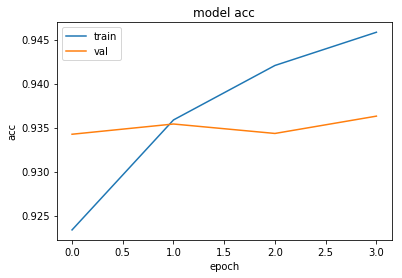

In [29]:
import matplotlib.pyplot as plt
print(h.history.keys())
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Строчка 6

Поиск аутлаеров в данных с помощью кластеризации (нужно найти хотя бы 20 странных не одинаковых текста)  - 1.5 балла

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MeanShift

In [33]:
cv = CountVectorizer(max_features=500)
cv_vec = cv.fit_transform(datka_train.comment_text)

In [34]:
svd = TruncatedSVD(50)
vectors_svd = svd.fit_transform(cv_vec)
cluster = MeanShift(cluster_all=False, bandwidth=0.1)
cluster.fit(vectors_svd)
labels = cluster.labels_

df = pd.DataFrame({
    'title': datka_train.comment_text,
    'label': labels,
})
df[df['label'] == -1].head(20)

,title,label
89,Thanks reading there now !,-1
177,"86.29.244.57|86.29.244.57]] 04:21, 14 May 2007",-1
510,"Belarus a developed country\nHahaha, nothing m...",-1
824,"16, 7 May 2007 (UTC)TimySmidge 21:",-1
883,I didn't receive any massage.,-1
899,I've just seen that,-1
1006,"The German Habilitation is a Degree, defined b...",-1
1040,"""\nKeegan found a proxy in one of the last soc...",-1
1095,"""\n Thanks ) • You Da One """,-1
1200,"Funny, I don't feel blocked.",-1


Как-то не очень выразительно. Прогоним ещё DBSCAN, вдруг получится лучше

In [35]:
from sklearn.cluster import DBSCAN

In [43]:
cluster2 = DBSCAN(min_samples=100, eps=0.4)
cluster2.fit(vectors_svd)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=100, n_jobs=None, p=None)

In [45]:
labels = cluster2.labels_

df = pd.DataFrame({
    'title': datka_train.comment_text,
    'label': labels,
})
df[df['label'] == -1].head(20)

,title,label
0,Explanation\nWhy the edits made under my usern...,-1
1,D'aww! He matches this background colour I'm s...,-1
2,"Hey man, I'm really not trying to edit war. It...",-1
3,"""\nMore\nI can't make any real suggestions on ...",-1
4,"You, sir, are my hero. Any chance you remember...",-1
5,"""\n\nCongratulations from me as well, use the ...",-1
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,-1
7,Your vandalism to the Matt Shirvington article...,-1
8,Sorry if the word 'nonsense' was offensive to ...,-1
9,alignment on this subject and which are contra...,-1


Да, совсем мимо, попробовал разные параметры, вообще никак